# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [19]:
data_dir = './input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

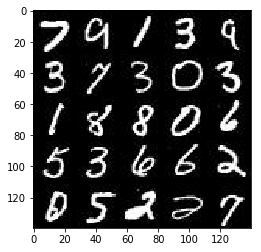

In [20]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

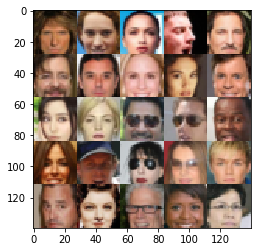

In [21]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [23]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    real_inputs = tf.placeholder(
        tf.float32, 
        (None, image_height, image_width, image_channels),
        name='real_inputs'
    )
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name='z_inputs')
    lrate = tf.placeholder(tf.float32, name='lrate')
    return real_inputs, z_inputs, lrate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [24]:
def discriminator(images, reuse=False, alpha=0.2, kernel=5, filters=64):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Input layer is 28x28x3
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, filters, kernel, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x32
        
        x2 = tf.layers.conv2d(x1, filters*2, kernel, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x64
        
        flat = tf.reshape(relu2, (-1, 7*7*filters*2))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [25]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128
        
        logits = tf.layers.conv2d_transpose(
            x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)






Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [26]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(gen_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=tf.ones_like(d_model_real)
        )
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)
        )
    )
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.ones_like(d_model_fake)
        )
    )
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [27]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [28]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [ ]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    steps=0
    
    # TODO: Build Model
    image_channels = 3 if data_image_mode == 'RGB' else 1
    image_height, image_width = data_shape[1], data_shape[2]
    real_inputs, z_inputs, lrate = model_inputs(
        image_width, image_height, image_channels, z_dim)
        
    d_loss, g_loss = model_loss(real_inputs, z_inputs, image_channels)
    
    d_opt, g_opt = model_opt(d_loss, g_loss, lrate, beta1)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                batch_images = 2 * batch_images
                
                batch_z = np.random.uniform(-1 ,1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                    real_inputs: batch_images,
                    z_inputs: batch_z,
                    lrate: learning_rate
                })
                _ = sess.run(g_opt, feed_dict={
                    z_inputs: batch_z,
                    real_inputs: batch_images,
                    lrate: learning_rate
                })
                
                if steps % 10 == 0:
                    # At the end of every 10 epochs, get the losses and print them out
                    train_loss_d = d_loss.eval({z_inputs: batch_z, real_inputs: batch_images})
                    train_loss_g = g_loss.eval({z_inputs: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g),
                          "Sum Loss: {:.4f}".format(train_loss_g+train_loss_d))
                
                if steps % 100 == 0:
                    show_generator_output(
                        sess,
                        16,
                        z_inputs,
                        image_channels,
                        data_image_mode
                    )
                  
        show_generator_output(sess, 16, z_inputs, image_channels, data_image_mode)

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0027... Generator Loss: 10.7260 Sum Loss: 10.7287
Epoch 1/2... Discriminator Loss: 0.0174... Generator Loss: 4.1930 Sum Loss: 4.2103
Epoch 1/2... Discriminator Loss: 0.1434... Generator Loss: 6.9461 Sum Loss: 7.0895
Epoch 1/2... Discriminator Loss: 0.0630... Generator Loss: 5.2090 Sum Loss: 5.2721
Epoch 1/2... Discriminator Loss: 0.0426... Generator Loss: 3.8469 Sum Loss: 3.8894
Epoch 1/2... Discriminator Loss: 0.0084... Generator Loss: 6.0034 Sum Loss: 6.0118
Epoch 1/2... Discriminator Loss: 0.0125... Generator Loss: 5.3059 Sum Loss: 5.3184
Epoch 1/2... Discriminator Loss: 0.0202... Generator Loss: 4.7409 Sum Loss: 4.7611
Epoch 1/2... Discriminator Loss: 0.0192... Generator Loss: 5.2948 Sum Loss: 5.3140
Epoch 1/2... Discriminator Loss: 0.0081... Generator Loss: 5.8604 Sum Loss: 5.8686


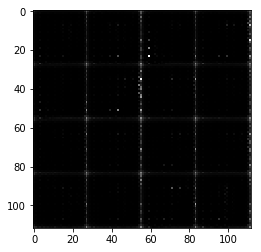

Epoch 1/2... Discriminator Loss: 0.0061... Generator Loss: 5.6903 Sum Loss: 5.6965
Epoch 1/2... Discriminator Loss: 0.0068... Generator Loss: 5.7841 Sum Loss: 5.7909
Epoch 1/2... Discriminator Loss: 0.0649... Generator Loss: 12.2897 Sum Loss: 12.3546
Epoch 1/2... Discriminator Loss: 4.1353... Generator Loss: 0.0559 Sum Loss: 4.1912
Epoch 1/2... Discriminator Loss: 1.3072... Generator Loss: 0.8036 Sum Loss: 2.1108
Epoch 1/2... Discriminator Loss: 0.5484... Generator Loss: 2.4927 Sum Loss: 3.0411
Epoch 1/2... Discriminator Loss: 0.6363... Generator Loss: 1.8026 Sum Loss: 2.4389
Epoch 1/2... Discriminator Loss: 1.0041... Generator Loss: 0.8109 Sum Loss: 1.8151
Epoch 1/2... Discriminator Loss: 0.8009... Generator Loss: 1.1787 Sum Loss: 1.9796
Epoch 1/2... Discriminator Loss: 0.9075... Generator Loss: 0.9471 Sum Loss: 1.8545


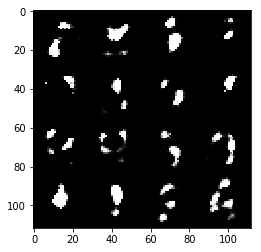

Epoch 1/2... Discriminator Loss: 0.9413... Generator Loss: 0.7116 Sum Loss: 1.6529
Epoch 1/2... Discriminator Loss: 0.8455... Generator Loss: 1.4160 Sum Loss: 2.2615
Epoch 1/2... Discriminator Loss: 1.0813... Generator Loss: 0.7300 Sum Loss: 1.8113
Epoch 1/2... Discriminator Loss: 1.9127... Generator Loss: 0.2333 Sum Loss: 2.1460
Epoch 1/2... Discriminator Loss: 1.0017... Generator Loss: 1.4332 Sum Loss: 2.4348
Epoch 1/2... Discriminator Loss: 1.7912... Generator Loss: 0.5258 Sum Loss: 2.3170
Epoch 1/2... Discriminator Loss: 1.2802... Generator Loss: 0.6841 Sum Loss: 1.9643
Epoch 1/2... Discriminator Loss: 1.7704... Generator Loss: 0.6188 Sum Loss: 2.3893
Epoch 1/2... Discriminator Loss: 1.6747... Generator Loss: 0.4956 Sum Loss: 2.1703
Epoch 1/2... Discriminator Loss: 2.2257... Generator Loss: 1.4334 Sum Loss: 3.6591


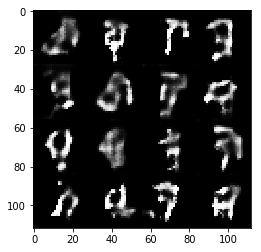

Epoch 1/2... Discriminator Loss: 1.7177... Generator Loss: 0.5097 Sum Loss: 2.2273
Epoch 1/2... Discriminator Loss: 1.3909... Generator Loss: 0.8658 Sum Loss: 2.2567
Epoch 1/2... Discriminator Loss: 1.3337... Generator Loss: 1.2020 Sum Loss: 2.5357
Epoch 1/2... Discriminator Loss: 1.5045... Generator Loss: 0.8197 Sum Loss: 2.3243
Epoch 1/2... Discriminator Loss: 1.3211... Generator Loss: 0.6522 Sum Loss: 1.9733
Epoch 1/2... Discriminator Loss: 1.2388... Generator Loss: 0.7620 Sum Loss: 2.0008
Epoch 1/2... Discriminator Loss: 1.2814... Generator Loss: 0.8042 Sum Loss: 2.0856
Epoch 1/2... Discriminator Loss: 1.4352... Generator Loss: 1.4323 Sum Loss: 2.8674
Epoch 1/2... Discriminator Loss: 1.3151... Generator Loss: 0.5958 Sum Loss: 1.9109
Epoch 1/2... Discriminator Loss: 1.4451... Generator Loss: 0.4268 Sum Loss: 1.8719


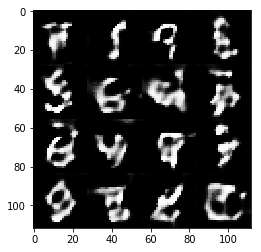

Epoch 1/2... Discriminator Loss: 1.2874... Generator Loss: 1.0066 Sum Loss: 2.2940
Epoch 1/2... Discriminator Loss: 1.3461... Generator Loss: 0.6185 Sum Loss: 1.9646
Epoch 1/2... Discriminator Loss: 1.4917... Generator Loss: 0.5920 Sum Loss: 2.0837
Epoch 1/2... Discriminator Loss: 1.7578... Generator Loss: 0.3545 Sum Loss: 2.1123
Epoch 1/2... Discriminator Loss: 1.4344... Generator Loss: 0.8387 Sum Loss: 2.2731
Epoch 1/2... Discriminator Loss: 1.3594... Generator Loss: 1.0442 Sum Loss: 2.4036
Epoch 2/2... Discriminator Loss: 1.2944... Generator Loss: 0.6838 Sum Loss: 1.9782
Epoch 2/2... Discriminator Loss: 1.3852... Generator Loss: 1.0932 Sum Loss: 2.4783
Epoch 2/2... Discriminator Loss: 1.4538... Generator Loss: 0.9915 Sum Loss: 2.4453
Epoch 2/2... Discriminator Loss: 1.3815... Generator Loss: 0.8345 Sum Loss: 2.2161


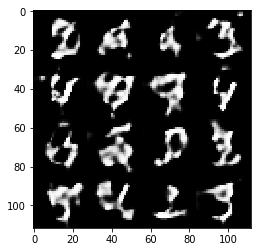

Epoch 2/2... Discriminator Loss: 1.3219... Generator Loss: 1.0312 Sum Loss: 2.3531
Epoch 2/2... Discriminator Loss: 1.3540... Generator Loss: 0.9389 Sum Loss: 2.2929
Epoch 2/2... Discriminator Loss: 1.2885... Generator Loss: 0.9219 Sum Loss: 2.2104
Epoch 2/2... Discriminator Loss: 1.2881... Generator Loss: 0.7755 Sum Loss: 2.0635
Epoch 2/2... Discriminator Loss: 1.1983... Generator Loss: 0.7382 Sum Loss: 1.9365
Epoch 2/2... Discriminator Loss: 1.2555... Generator Loss: 0.5733 Sum Loss: 1.8287
Epoch 2/2... Discriminator Loss: 1.2497... Generator Loss: 1.2711 Sum Loss: 2.5208
Epoch 2/2... Discriminator Loss: 1.1853... Generator Loss: 0.8935 Sum Loss: 2.0788
Epoch 2/2... Discriminator Loss: 1.3746... Generator Loss: 0.7006 Sum Loss: 2.0752
Epoch 2/2... Discriminator Loss: 1.3563... Generator Loss: 0.8568 Sum Loss: 2.2131


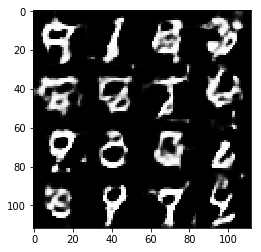

Epoch 2/2... Discriminator Loss: 1.4888... Generator Loss: 0.4576 Sum Loss: 1.9464
Epoch 2/2... Discriminator Loss: 1.4608... Generator Loss: 1.2757 Sum Loss: 2.7365
Epoch 2/2... Discriminator Loss: 1.4780... Generator Loss: 1.1662 Sum Loss: 2.6442
Epoch 2/2... Discriminator Loss: 1.2629... Generator Loss: 0.7094 Sum Loss: 1.9723
Epoch 2/2... Discriminator Loss: 1.1771... Generator Loss: 0.8612 Sum Loss: 2.0384
Epoch 2/2... Discriminator Loss: 1.1631... Generator Loss: 0.7472 Sum Loss: 1.9102
Epoch 2/2... Discriminator Loss: 1.2696... Generator Loss: 0.7527 Sum Loss: 2.0224
Epoch 2/2... Discriminator Loss: 1.4152... Generator Loss: 0.6327 Sum Loss: 2.0479
Epoch 2/2... Discriminator Loss: 1.5294... Generator Loss: 0.5369 Sum Loss: 2.0664


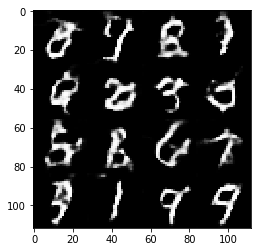

Epoch 2/2... Discriminator Loss: 1.4919... Generator Loss: 0.5623 Sum Loss: 2.0542
Epoch 2/2... Discriminator Loss: 1.3400... Generator Loss: 0.7131 Sum Loss: 2.0531
Epoch 2/2... Discriminator Loss: 1.1939... Generator Loss: 0.7587 Sum Loss: 1.9526
Epoch 2/2... Discriminator Loss: 1.2526... Generator Loss: 0.6728 Sum Loss: 1.9254
Epoch 2/2... Discriminator Loss: 1.4156... Generator Loss: 0.4939 Sum Loss: 1.9095
Epoch 2/2... Discriminator Loss: 1.4914... Generator Loss: 0.7321 Sum Loss: 2.2235
Epoch 2/2... Discriminator Loss: 1.3482... Generator Loss: 0.7170 Sum Loss: 2.0652
Epoch 2/2... Discriminator Loss: 1.4053... Generator Loss: 0.5365 Sum Loss: 1.9418
Epoch 2/2... Discriminator Loss: 1.3339... Generator Loss: 0.7555 Sum Loss: 2.0894
Epoch 2/2... Discriminator Loss: 1.3742... Generator Loss: 0.6799 Sum Loss: 2.0541


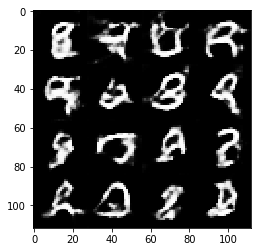

Epoch 2/2... Discriminator Loss: 1.3754... Generator Loss: 0.7438 Sum Loss: 2.1192
Epoch 2/2... Discriminator Loss: 1.2605... Generator Loss: 0.7459 Sum Loss: 2.0064
Epoch 2/2... Discriminator Loss: 1.2703... Generator Loss: 0.9796 Sum Loss: 2.2499
Epoch 2/2... Discriminator Loss: 1.4242... Generator Loss: 1.2014 Sum Loss: 2.6257
Epoch 2/2... Discriminator Loss: 1.3572... Generator Loss: 0.5985 Sum Loss: 1.9557
Epoch 2/2... Discriminator Loss: 1.3096... Generator Loss: 0.6350 Sum Loss: 1.9446
Epoch 2/2... Discriminator Loss: 1.3169... Generator Loss: 0.6228 Sum Loss: 1.9397
Epoch 2/2... Discriminator Loss: 1.3316... Generator Loss: 0.8531 Sum Loss: 2.1847
Epoch 2/2... Discriminator Loss: 1.4596... Generator Loss: 0.4994 Sum Loss: 1.9589
Epoch 2/2... Discriminator Loss: 1.3630... Generator Loss: 0.6273 Sum Loss: 1.9903


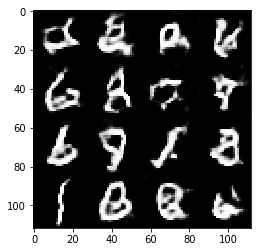

Epoch 2/2... Discriminator Loss: 1.2964... Generator Loss: 0.7887 Sum Loss: 2.0851
Epoch 2/2... Discriminator Loss: 1.4204... Generator Loss: 0.4807 Sum Loss: 1.9011
Epoch 2/2... Discriminator Loss: 1.4242... Generator Loss: 0.4672 Sum Loss: 1.8914


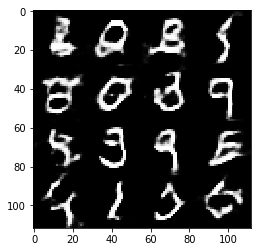

In [ ]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.